# Text Classification Using Logistic Regression

# 1. Load Data

In [47]:
import warnings

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score # get a specific score of a model using CV
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a list of english stop words
from sklearn.preprocessing import LabelEncoder

from sklearn.exceptions import ConvergenceWarning

In [48]:
df_train = pd.read_csv("training.csv")
df_train.head()
df_train.shape

df_test = pd.read_csv("test.csv")
df_test.head()
df_test.shape

,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


(9500, 3)

,article_number,article_words,topic
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT


(500, 3)

## 1.1 Training Test Sets Building
"IRRELEVANT" is included

In [49]:
text_train = df_train.article_words # training set containing text content
label_train = df_train.topic

# encode labels to integers 0-10 
encoder = LabelEncoder().fit(label_train)
y_train = encoder.transform(label_train)
y_train
type(y_train)
y_train.shape

# Insert the encoded column in to original dataframe
df_train["label"] = y_train
df_train.head()

array([ 4,  7, 10, ...,  4,  6,  4])

numpy.ndarray

(9500,)

,article_number,article_words,topic,label
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,4
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,7
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,10
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,4
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,6


In [50]:
text_test = df_test.article_words

# encode labels to integers 0-10 
y_test = encoder.transform(df_test.topic)
y_test.shape

# number of entries in each calss, including irrelevant
np.bincount(y_test)

# Insert the encoded column in to original dataframe
df_test["label"] = y_test
df_test.head()

(500,)

array([  3,  15,  13,   2,  48,  14, 266,  69,   3,   7,  60])

,article_number,article_words,topic,label
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT,6
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT,6
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS,4
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT,6
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT,6


# 2. Feature Engineering as Bag of Words (BoW)
## 2.1 Count Vector
Ignore shape of texts, focus on individual words (sometimes multiple words back to back)

- Tokenization
- Vocabulary building
    - **all** words that appear in **all** of the documents in the corpus, and number them (say, in alphabetic order)
- Encodeing
    - for each **document**, count how often each word in the vocabulary appear in this document:
        - 0 if not present
    
See the example below: adoped from the same chapter of the book
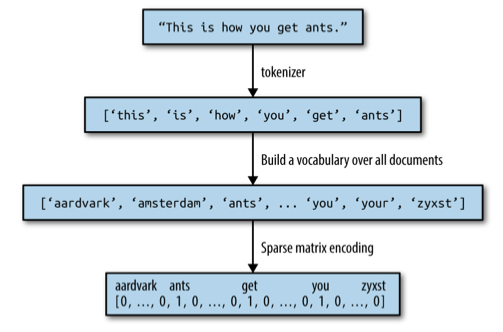

<div align="center">
    Process of BoW
</div>

In [51]:
vect = CountVectorizer().fit(text_train)
print(f"vocabulary size: {len(vect.vocabulary_)}")

vocabulary size: 35822


In [52]:
features = vect.get_feature_names()
print(f"The first 20 features:\n{features[:20]}")
print("\nFeatures 20010 to 20030:\n{}".format(features[20010:20030]))
print("\nEvery 2000th feature:\n{}".format(features[::2000]))

The first 20 features:
['_____', '______', '_______', '____________', '_bret', 'a1', 'a1b1', 'a2', 'a3', 'a300', 'a300b4', 'a320', 'a330', 'a340', 'a4', 'a5', 'a6', 'a7', 'a78', 'a7e']

Features 20010 to 20030:
['menzy', 'mep', 'mer', 'meralc', 'merc', 'mercad', 'mercado', 'mercantil', 'mercaton', 'merced', 'mercen', 'merch', 'merchandis', 'merci', 'mercilon', 'merck', 'merckx', 'mercosur', 'mercur', 'mercurio']

Every 2000th feature:
['_____', 'athibid', 'boulai', 'clar', 'derrick', 'essilor', 'generat', 'hochschild', 'joing', 'lepag', 'menot', 'nissim', 'persever', 'real', 'schipol', 'stamped', 'tollefson', 'vire']


**It can be observed that there are some none alpha-numeric characters**, 

these features might not be very descripative so next we'll remove them:

In [53]:
# remove "_" in each document
text_train = df_train.article_words.apply(lambda x: x.replace('_', ''))

# refit the vectorizer to text_train
vect = CountVectorizer().fit(text_train)
features = vect.get_feature_names()

print(f"The first 40 features:\n{features[:40]}")
print("\nFeatures 20010 to 20050:\n{}".format(features[20010:20040]))
print("\nEvery 1000th feature:\n{}".format(features[::1000]))

The first 40 features:
['a1', 'a1b1', 'a2', 'a3', 'a300', 'a300b4', 'a320', 'a330', 'a340', 'a4', 'a5', 'a6', 'a7', 'a78', 'a7e', 'aa', 'aa1', 'aa2', 'aa3', 'aaa', 'aacount', 'aad', 'aadj', 'aag', 'aah', 'aahp', 'aair', 'aalborg', 'aalst', 'aalton', 'aaltonaa', 'aama', 'aamir', 'aamodt', 'aandewiel', 'aap', 'aapc', 'aapt', 'aaqib', 'aaquib']

Features 20010 to 20050:
['mercad', 'mercado', 'mercantil', 'mercaton', 'merced', 'mercen', 'merch', 'merchandis', 'merci', 'mercilon', 'merck', 'merckx', 'mercosur', 'mercur', 'mercurio', 'mercy', 'merdior', 'mere', 'merebank', 'meret', 'merg', 'merial', 'merid', 'meridian', 'meridor', 'merin', 'meris', 'merisel', 'merit', 'meriwether']

Every 1000th feature:
['a1', 'altamir', 'atkin', 'beke', 'boulton', 'cardiothorac', 'clarin', 'credent', 'desant', 'dump', 'est', 'flap', 'genev', 'guotai', 'hockeyroo', 'inflexibl', 'joke', 'koek', 'leppan', 'mainstay', 'mentheor', 'movie', 'nitchipourenk', 'ota', 'person', 'prevar', 'realloc', 'rollin', 'schles

Now the features are cleaner, next transform the training set into tf-idf matrix:

In [54]:
%%time
X_train = vect.transform(text_train)
print(f"X_train:\n {repr(X_train)}")
print(f"Type of X_train:\n {type(X_train)}")

X_train:
 <9500x35817 sparse matrix of type '<class 'numpy.int64'>'
	with 760415 stored elements in Compressed Sparse Row format>
Type of X_train:
 <class 'scipy.sparse.csr.csr_matrix'>
CPU times: user 1.1 s, sys: 23.7 ms, total: 1.13 s
Wall time: 1.14 s


## 2.2 Try to fit a model
The matrix still need to be further engineered, more on that later.

For now, let’s obtain a quantitative measure of performance by actually building a classifier.

### 2.2.1 logistic regression
The data matrix is now very **high dimensional** (35817 features), and **sparse** (most values in the matrix X_train are 0). For dataset like this, linear models like `LogisticRegression` often work best.

In [55]:
%%time
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all

accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train, y_train, cv=5)
print(f"Mean accuracy (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")

Mean accuracy (std):  0.751 ( 0.005)
CPU times: user 987 ms, sys: 108 ms, total: 1.1 s
Wall time: 43 s


### 2.2.2 Tune the model
We get an accuracy of 0.75, let's see if it can be improved.

We know that logistic regression has a regularization term $C\sum_{i=1}^{D}\lambda_i^2$ (l2 regularization), and 'C' is a parameter we can optimize here.

C = \[0.001, 0.01, 0.1, 1.0, 10.0\], (C=1.0 by LogisticRegression default)

In [56]:
param_grid = {'C': np.geomspace(0.001,10,num=5,endpoint=True)}
param_grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}

In [57]:
%%time
grid = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

CPU times: user 284 ms, sys: 49.5 ms, total: 333 ms
Wall time: 3min 22s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
print(f"best parameter: {grid.best_params_}")
print(f"best 5-fold CV score (accuracy): {grid.best_score_: .3f}")

best parameter: {'C': 0.1}
best 5-fold CV score (accuracy):  0.758


### 2.2.3 Test on test set
GridSearchCV by default <font color='blue'>**refit**</font> the model passed in with best parameters, and can be used directly on test sets.

In [59]:
%%time
X_test = vect.transform(text_test)
acc_test = grid.score(X_test, y_test)
print(f"Logistic regression accuracy on test set: {acc_test:.3f}")

Logistic regression accuracy on test set: 0.746
CPU times: user 84.2 ms, sys: 4.4 ms, total: 88.6 ms
Wall time: 91 ms


## 2.3 Improve the feature extraction
CounterVectorizer extacts tokens use `r"\b\w\w+\b"` which means 2 or more conscecutive characters between two word boundaries `("\'", ',', '_', '.', ' ', '-' ...)`

### 2.3.1 Set a minimum number of documents a token needs to be appear in, with the `min_df` parameter, in order to be considered as a feature.

In [60]:
%%time
vect_1 = CountVectorizer(min_df=5).fit(text_train)
X_train_1 = vect_1.transform(text_train)

print(f"X_train:\n {repr(X_train)}")
print(f"X_train with min_df=5:\n {repr(X_train_1)}")

X_train:
 <9500x35817 sparse matrix of type '<class 'numpy.int64'>'
	with 760415 stored elements in Compressed Sparse Row format>
X_train with min_df=5:
 <9500x9495 sparse matrix of type '<class 'numpy.int64'>'
	with 719745 stored elements in Compressed Sparse Row format>
CPU times: user 2.37 s, sys: 60.6 ms, total: 2.43 s
Wall time: 2.5 s


In [61]:
features_1 = vect_1.get_feature_names()
print("First 50 features:\n{}".format(features_1[:50])) 
print("\nFeatures 5010 to 5050:\n{}".format(features_1[5010:5050])) 
print("\nEvery 300th feature:\n{}".format(features_1[::300]))

First 50 features:
['a1', 'a2', 'a3', 'aa', 'aa1', 'aa2', 'aa3', 'aaa', 'aamir', 'aamodt', 'ab', 'abach', 'abandon', 'abat', 'abb', 'abba', 'abbey', 'abbrev', 'abc', 'abdel', 'abdomin', 'abduc', 'abdul', 'abdullah', 'abel', 'aberdeen', 'abid', 'abidj', 'abigail', 'abil', 'abn', 'abnorm', 'aboard', 'abol', 'abort', 'abou', 'abound', 'abraham', 'abroad', 'abrupt', 'absent', 'absolut', 'absorb', 'abstain', 'abstract', 'absurd', 'abu', 'abund', 'abus', 'ac']

Features 5010 to 5050:
['luc', 'luca', 'lucid', 'luck', 'lucky', 'lucrat', 'ludov', 'lufkin', 'lufthans', 'lui', 'luig', 'lukashenk', 'lukewarm', 'lukoil', 'lull', 'lumb', 'lump', 'lumpur', 'lunar', 'lunch', 'luncheon', 'lunchtim', 'lung', 'lurch', 'lure', 'lurk', 'luther', 'luton', 'lux', 'luxembourg', 'luxur', 'lvl', 'lvmh', 'lyddon', 'lying', 'lyl', 'lyn', 'lynch', 'lyon', 'lyonnai']

Every 300th feature:
['a1', 'amount', 'avert', 'binh', 'bumpy', 'cheer', 'congratul', 'dare', 'disney', 'els', 'fall', 'fras', 'grappl', 'hirosh', 'i

### 2.3.2 Train the model again

In [62]:
%%time
grid = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid, cv=5, n_jobs=-1) 
grid.fit(X_train_1, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.759
Best parameters: {'C': 0.1}
CPU times: user 324 ms, sys: 43.4 ms, total: 367 ms
Wall time: 1min 6s


In [63]:
X_test_1 = vect_1.transform(text_test)
acc_test = grid.score(X_test_1, y_test)
print(f"Logistic regression accuracy on test set: {acc_test:.3f}")

Logistic regression accuracy on test set: 0.748


# 3. Optimize the Model

This is a multiclass problem, logistic regression has several parameters that we can adjust:
- `solver`. Algorithm to use in the optimization problem. For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
- `class_weight: {"balanced", None}, default=None`. "balanced" will adjust weights inversly proportional to class frequencies, i.e penalise large class.
- `multi_class: {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’`. 
    - `ovr`: one-versus-rest, essentially a binary problem is fit for each label
    - `multinomial`: the loss function is the multinomial loss fit across the entire probability distribution
- `C: default=1.0`. Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- `penalty`: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’, 'saga' and ‘lbfgs’ solvers support only l2 penalties.

Tf-idf is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

- tf: term frequency in one document

- idf: inverse document frequency

In a **document**, the most frequent words tend to be more descripative of the document.

**But** words like "a", "the", "what" appear everywhere in all kinds of documents, they are not good keywords to distinguish documents.

Instead we are more interested in words that appear only in this specific document we are studying.

$$TFIDF(w,d) = tf\cdot log(\frac{N_d+1}{N_{d|w} + 1}) + 1$$
$N_d$: the number of documents in the training set

$N_{d|w}$: the number of documents in the training set that contains the word $w$

tf-idf is usually l2-normalized, i.e. the norm of the feature vector transformed from a document is 1.

## 3.1 One Subtlety with GridSearchCV
In GridSearchCV, the training set is further splited into (k-1) <font color='red'>**training**</font> and 1 <font color='green'>**validating**</font> folds, where the <font color='green'>**validating**</font> set is supposed to simulate the <font color='blue'>**test**</font> set (unseen data).

Often, our fisrt step is to perform normalization (aka rescaling, e.g min_max) to the whole `X_train`.

Meaning that we have collected statistical infomation from the <font color='green'>**validating**</font> set before using it to validate our model.

This is clearly not the case for test set, we do not know anything (e.g. min, max) about the test set when learning a model, in other words, the <font color='green'>**validating**</font> set splitted from training set **after** such normalization fails to simulate completely unseen data:
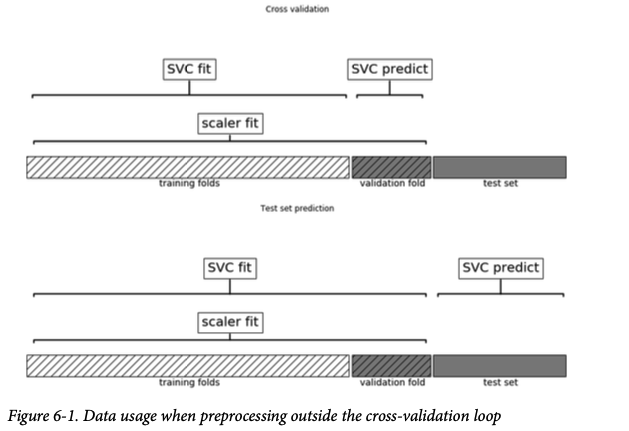

Idealy, each split in cross validation should apply normalization to the (k-1) <font color='red'>**training**</font> folds respectively, but leave out the 1 <font color='green'>**validating**</font> fold while doing so:
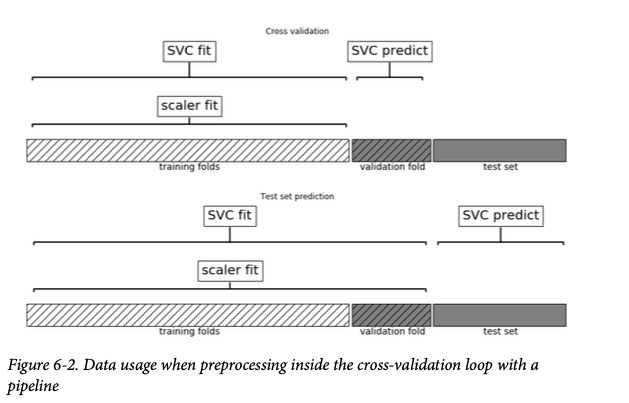

Since both `tf-idf` and `class_weight` parameter of `logistic regression` (when set to "balanced") use statistical information of the whole training set, but in cross-validation we do not want the validat set (simulating unseen samples) to leak information before prediction, in order to perform a valid grid search, here we use [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class.



In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline

In [68]:
# standard pipeline interface
estimators = [
              ("tfidf", TfidfVectorizer(min_df=5, norm=None)),
              ("LR", LogisticRegression(n_jobs=-1))
             ]

pipe = Pipeline(estimators)

# Notice here parameters need to be specified to which step in the pipeline they belong to
param_grid = {
#               "tfidf__min_df": [3, 5, 7],
#               "LR__solver": ['newton-cg', 'sag', 'saga', 'lbfgs'],
              "LR__class_weight": ["balanced", None],
              "LR__multi_class": ["ovr", "multinomial"],
              "LR__C": [0.001, 0.01, 0.1, 1, 10],
#               "LR__penalty": ["l1", "l2"]
             }
pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [69]:
%%time
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)

# through in original text samples
grid.fit(text_train, y_train)

CPU times: user 4.69 s, sys: 2.52 s, total: 7.21 s
Wall time: 8min 37s


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                                        

In [86]:
# Extract the optimal steps we have obtained sofar
clf_logi = grid.best_estimator_
print(f"Optimal logistic regression steps:\n{clf_logi}")

# Report accuracy scores on training and test set
acc_train = grid.best_score_
print(f"Best parameter: {grid.best_params_}")
print(f"Accuracy on training set: {acc_train:.3f}")

y_pred = clf_logi.predict(text_test)
y_pred_pr = clf_logi.predict_proba(text_test)
acc_test = clf_logi.score(text_test, y_test)
print(f"Accuracy on test set: {acc_test:.3f}")

Optimal logistic regression steps:
Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LR',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    dual=Fa

# 4 Analyzing the Result
The training accuracy is not very high (0.788), for now that's all I can get. Nevertheless, we shuld analyse the model:

## 4.1 Classification Report

In [194]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs # compute scores for each class

In [88]:
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.80      0.53      0.64        15
           2       0.82      0.69      0.75        13
           3       0.50      1.00      0.67         2
           4       0.51      0.62      0.56        48
           5       0.64      0.50      0.56        14
           6       0.92      0.85      0.88       266
           7       0.57      0.62      0.59        69
           8       0.00      0.00      0.00         3
           9       0.56      0.71      0.63         7
          10       0.95      1.00      0.98        60

    accuracy                           0.79       500
   macro avg       0.61      0.69      0.63       500
weighted avg       0.81      0.79      0.79       500



## <font color='red'>Problem: None of the 3 "Science and technology" articles is correctly predicted.</font>

## 4.2 Confusion Matrix

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

In [142]:
# Compute confusion matrix on test set
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[  3   0   0   0   0   0   0   0   0   0   0]
 [  2   8   0   0   0   0   5   0   0   0   0]
 [  0   0   9   0   0   0   4   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0  30   0   3  14   0   1   0]
 [  0   0   0   0   0   7   3   0   4   0   0]
 [  0   2   2   2   5   3 227  19   0   3   3]
 [  0   0   0   0  24   0   2  43   0   0   0]
 [  1   0   0   0   0   1   1   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0  60]]


Text(0.5, 1, 'Confusion Matrix on Test Set | Classifier: tfidf+LR')

Text(0.5, 33.0, 'Actual: False positives for y != x')

Text(95.99999999999999, 0.5, 'Prediction: False negatives for x != y')

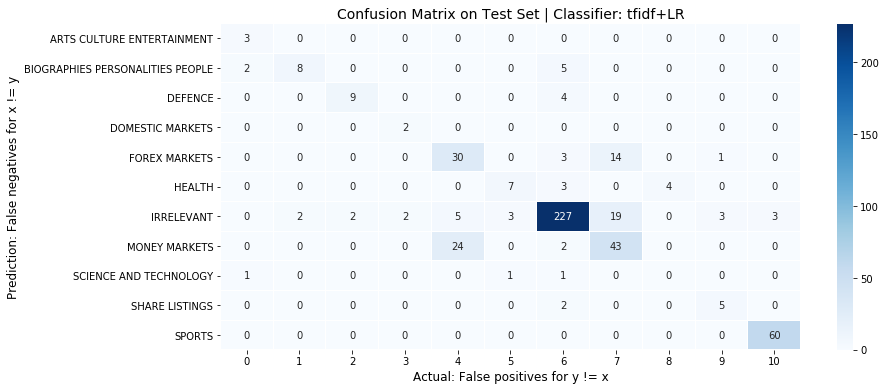

In [226]:
fig1 = plt.figure(figsize=(13,6))
sns.heatmap(conf_matrix,
#             square=True,
            annot=True, # show numbers in each cell
            fmt='d', # set number format to integer in each cell
            yticklabels=encoder.classes_,
            xticklabels=clf_logi.classes_,
            cmap="Blues",
#             linecolor="k",
            linewidths=.1,
           )
plt.title(
          f"Confusion Matrix on Test Set | " 
          f"Classifier: {'+'.join([step for step in clf_logi.named_steps.keys()])}", 
          fontsize=14)
plt.xlabel("Actual: False positives for y != x", fontsize=12)
plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
plt.show()

In [195]:
precision, recall, f1, support = prfs(y_test, y_pred)

# TO DO: plot

# 5 Export the Model
## 5.1 Create a dataset with model summaries to compare models:

In [216]:
model_summary = {
    "Model": '+'.join([step for step in clf_logi.named_steps.keys()]),
    "Training accuracy": f"{acc_train:.3f}",
    "Test accuracy": f"{acc_test:.3f}"
}

model_collection = pd.DataFrame(model_summary, index=[0])
model_collection

,Model,Training accuracy,Test accuracy
0,tfidf+LR,0.775,0.788


## 5.2 Export the Model
Save the model and the collection dataset.

In [3]:
import os
from joblib import dump, load

In [10]:
file_name = "Models/best_logi.joblib"
if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
    with open(file_name, "wb") as file:
        joblib.dump(clf_logi, file, compress=True)
else:
    print("Warn: this model already exits...")

Warn: this model already exits...
